<h1 style="text-align: center">Predicting Liklihood of Extinction</h1>
<h3 style="text-align: center">With Logistic Regression</h3>

There are many endangered languages in the world today. Many that have already gone extinct. I would like to know what features cause a language to go extinct. 

There are many variables to consider when dissecting this problem and I by no means will have a definitive answer. This problem may not even be a problem which can be solved by machine learning, nonetheless I’d like to state my hypothesis and go over try and predict what makes a langague extinct?

In [34]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

from sklearn.utils import resample

sns.set()
%matplotlib inline

endangered_languages = pd.read_csv('../data_sets/endangered_languages_ML.csv')
X = endangered_languages.drop(['Language', 'Extinct'], axis=1)
y = endangered_languages['Extinct']
print(X.shape)
print(y.shape)

(1933, 160)
(1933,)


Class 0: 1740
Class 1: 193
Proportion: 9.02 : 1


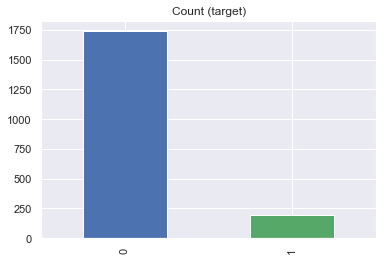

In [35]:
target_count = y.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)', color=['b', 'g']);

A quick glance at what classes I'm trying to predict using the my logistic regression model, I notice that the target classes are quite imbalanced. Taking a look at the graph, we can see that the number of target extinct language class (1) is small compared to the number of target non-extinct language class (0). Approximately a 9 to 1 imbalance. So we can do some data resampling to correct this issue before running the model on the data.

One of the major issues with this not being handled is that any simple metrics used to evaluate the model can be misleading. In a dataset with highly unbalanced classes, if the classifier always "predicts" the most common class without performing any analysis of the features, it will still have a high accuracy rate.

<h2>Balancing the data:</h2>

Up-sampling is the process of randomly duplicating observations from the minority class in order to reinforce its signal.There are several heuristics for doing so, but the most common way is to simply resample with replacement.

In [8]:
df_majority = endangered_languages[endangered_languages['Extinct'] == 0]
df_minority = endangered_languages[endangered_languages['Extinct'] == 1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                  replace=True,     # sample with replacement
                                  n_samples=1740,    # to match majority class
                                  random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Extinct'].value_counts()

1    1740
0    1740
Name: Extinct, dtype: int64

In [9]:
log_reg = LogisticRegression(solver='lbfgs')

In [10]:
X = df_upsampled.drop(['Language', 'Extinct'], axis=1)
y = df_upsampled['Extinct']
print(X.shape)
print(y.shape)

(3480, 160)
(3480,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [12]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

[1]
0.514367816091954


While the accuracy seems about right, our model is only predicting class 1. Which means it's completely ignoring the non-extinct langauge class in favor of the extinct class. This may be due to upsampling which as I said above duplicates the minority class to reinforce it's signal. I'll try downsampling next, with hopes of a better accuracy score.

In [13]:
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=193,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['Extinct'].value_counts()

1    193
0    193
Name: Extinct, dtype: int64

In [14]:
X = df_downsampled.drop(['Language', 'Extinct'], axis=1)
y = df_downsampled['Extinct']
print(X.shape)
print(y.shape)

(386, 160)
(386,)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [17]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

[1]
0.5775862068965517


<h2>Scaling the Data:</h2>

The downsampled data recieved a better accuracy score, but still is misleading as the model once again only predicts 1 class. Let's see if standardizing the data before downsampling helps. Using RobustScaler, I will attempt to minimize the effect of outliers.

In [18]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(quantile_range=(25, 75))
col_names = endangered_languages.columns

col_list = list(col_names)
col_list.pop(0)

X = endangered_languages.drop(['Language'], axis=1)

scaled_langauges = scaler.fit_transform(X)

scaled_df = pd.DataFrame(scaled_langauges, columns=col_list)

scaled_df.shape

(1933, 161)

In [24]:
df_majority = scaled_df[scaled_df['Extinct'] == 0]
df_minority = scaled_df[scaled_df['Extinct'] == 1]

# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=193,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled['Extinct'].value_counts()

1.0    193
0.0    193
Name: Extinct, dtype: int64

In [25]:
X = df_downsampled.drop(['Extinct'], axis=1)
y = df_downsampled['Extinct']

(386, 160)
(386,)


<h2>Spliting, Testing and Training:</h2>

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

In [45]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

Clsses Predicted:  [0. 1.]
Accuracty:  0.5258620689655172


The model's accuracy jumped through the roof! It's not predicting just one class anymore.

<h2>Performance Metrics:</h2>

In [28]:
print(confusion_matrix(y_test, y_pred))

[[49  0]
 [ 1 66]]


Let’s interpret these results.

Out of the 49 extinct languages (first row), the classifier predicted correctly 49 of them.
Out of the 67 non-extinct languages (second row), the classifier predicted correctly 66 of them.
Out of all 116 languages, the classifier predicted correctly 115 of them

In [29]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        49
         1.0       1.00      0.99      0.99        67

   micro avg       0.99      0.99      0.99       116
   macro avg       0.99      0.99      0.99       116
weighted avg       0.99      0.99      0.99       116



#### ROC Curve

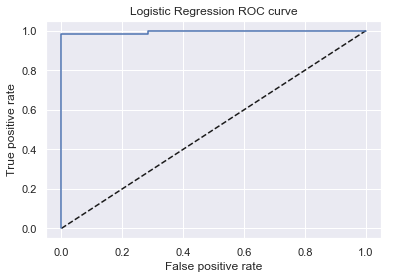

In [30]:
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.show()

In [38]:
roc_auc_score(y_test, y_pred_prob)

0.9957356076759062

<h2>Results... ?</h2>

Our model appears to be an incredibily accurate classifier of these classes basesd on the data. However, I'm skeptical to it's performance. My dataset has a few features I feel contribute to the high variance in this regression problem. 

Features like 'Speakers' which correlate 100% with extinction rate. Plus the other hot-encoded endangerment level features. If a single observation in my data (a row) doesn't have a 1 for one of either vulnerable, definietly, severely or critical endangerment than it has a 1 for extinct. I'd like to run my model a few times over with some other features missing to see what results I come up with

<h2>Feature Engineering</h2>

I'll continue using the scaled downsampled data because that was the one that resulted in two classes being predicted but these variations will have some other features selected

In [39]:
X = df_downsampled.drop(['Speakers', 'Extinct'], axis=1)
y = df_downsampled['Extinct']

(386, 159)
(386,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

[0. 1.]
1.0


Performing even better with speakers dropped... doesn't make sense. How about with the other level of endangerments dropped

In [46]:
X = df_downsampled.drop(['Speakers', 'Extinct', 'Critically endangered',
       'Definitely endangered', 'Extinct', 'Severely endangered',
       'Vulnerable'], axis=1)
y = df_downsampled['Extinct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

Clsses Predicted:  [0. 1.]
Accuracty:  0.5258620689655172


This makes some more sense as the model is actually having to do somre more work after not having these correlated features. I'll try removing one more which has a one to one ratio with the target class

In [47]:
X = df_downsampled.drop(['Speakers', 'Number of Countries Spoken', 'Extinct', 'Critically endangered',
       'Definitely endangered', 'Extinct', 'Severely endangered',
       'Vulnerable'], axis=1)
y = df_downsampled['Extinct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

Clsses Predicted:  [0. 1.]
Accuracty:  0.5431034482758621


Slowly raising it's accuracy. Let's boil down this data to the factors I believed from my hypothesis (which was that a low fertility rate, level of english proficiency and gdp could be factors leading to extinction. I found an interesting trend with the data. It does seem as though the features predict extinciton more and more if I include the level of endangerment. With model performance steadily increasing as the level of endangerment gets closer to extinction. 

### Vulnerable to Endangerment

In [56]:
X = df_downsampled[['Speakers', 'Fertility Rate Avg', '2018 Rank',
 '2018 Score', 'Number of Countries Spoken',
 'GDP Average (Current US $)', 'Vulnerable']]
y = df_downsampled['Extinct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

Clsses Predicted:  [0. 1.]
Accuracty:  0.7327586206896551


### Definitely Endangered

In [57]:
X = df_downsampled[['Speakers', 'Fertility Rate Avg', '2018 Rank',
 '2018 Score', 'Number of Countries Spoken',
 'GDP Average (Current US $)', 'Definitely endangered']]
y = df_downsampled['Extinct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

Clsses Predicted:  [0. 1.]
Accuracty:  0.75


### Severely Endangered

In [58]:
X = df_downsampled[['Speakers', 'Fertility Rate Avg', '2018 Rank',
 '2018 Score', 'Number of Countries Spoken',
 'GDP Average (Current US $)', 'Severely endangered']]
y = df_downsampled['Extinct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

Clsses Predicted:  [0. 1.]
Accuracty:  0.7586206896551724


### Critically Endangered

In [62]:
X = df_downsampled[['Speakers', 'Fertility Rate Avg', '2018 Rank',
 '2018 Score', 'Number of Countries Spoken',
 'GDP Average (Current US $)', 'Critically endangered']]
y = df_downsampled['Extinct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

Clsses Predicted:  [0. 1.]
Accuracty:  0.8103448275862069


Although I couldn't quite put my finger on it and I do feel as though there's much more to be gleaned from this data. At least, we do see an upward trend in accuracy as the model's main features were engineered for. Lets run the metrics on the critically endangered model

<h2>New Performance Metrics</h2>

In [64]:
print(confusion_matrix(y_test, y_pred))

[[28 21]
 [ 1 66]]


Out of the 49 extinct languages (first row), the classifier predicted correctly 28 of them.
Out of the 67 non-extinct languages (second row), the classifier predicted correctly 66 of them.

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.57      0.72        49
         1.0       0.76      0.99      0.86        67

   micro avg       0.81      0.81      0.81       116
   macro avg       0.86      0.78      0.79       116
weighted avg       0.85      0.81      0.80       116



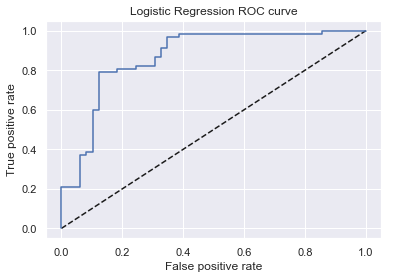

In [70]:
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regression ROC curve')
plt.show()

In [71]:
roc_auc_score(y_test, y_pred_prob)

0.8696314346634176

<h2>K-folds Cross Validation</h2>

In [72]:
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=5, scoring='roc_auc')
print(cv_scores)

[0.87002653 0.87034483 0.99724138 0.95862069 0.95714286]


## Hyperparameter tuning with GridSearchCV

In [87]:
# Setup the hyperparameter grid
c_space = np.logspace(-5, 8, 15)
param_grid = {'C': c_space}

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(log_reg, param_grid, cv=5)

# Fit it to the data
logreg_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

Tuned Logistic Regression Parameters: {'C': 163789.3706954068}
Best score is 0.9740740740740741


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [ ]:
<h2>With optimized C</h2>

In [80]:
log_reg = LogisticRegression(C=163789, solver='lbfgs')

X = df_downsampled[['Speakers', 'Fertility Rate Avg', '2018 Rank',
 '2018 Score', 'Number of Countries Spoken',
 'GDP Average (Current US $)', 'Critically endangered']]
y = df_downsampled['Extinct']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=33)

log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# How many classes is our model predicting?
print('Clsses Predicted: ', np.unique(y_pred))

# How's our accuracy now?
print('Accuracty: ', accuracy_score(y_test, y_pred))

Clsses Predicted:  [0. 1.]
Accuracty:  0.9396551724137931


<h1 style='text-align: center'>Conclusion</h2>